In [ ]:
import pandas as pd
agg_df_2023 = pd.read_csv('/content/X2.csv')


## Dataset filtered to 1 year (2023)

In [ ]:
agg_df_2023.columns

Index(['plant_code', 'state', 'steam_plant_type_full', 'year', 'sector',
       'fuel_consump_all_fuel_types_mmbtu', 'gross_gen_mwh', 'net_gen_mwh',
       'water_withdrawal_volume_mg', 'water_consumption_volume_mg'],
      dtype='object')

In [ ]:
agg_df_2023.shape

(538, 10)

In [ ]:
import numpy as np
# Step 1: select the features you want to cluster on
features = ['fuel_consump_all_fuel_types_mmbtu', 'gross_gen_mwh', 'net_gen_mwh',
            'water_withdrawal_volume_mg', 'water_consumption_volume_mg']

X = agg_df_2023[features]

# Step 2: drop rows with NaNs or infs in X *but keep the index*
X_clean = X.replace([np.inf, -np.inf], np.nan).dropna()

# Step 3: subset original DataFrame using the cleaned index to keep alignment
df_clean = agg_df_2023.loc[X_clean.index]

# Now X_clean and df_clean are perfectly aligned


# Understanding 'Principal Component Analysis'

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_clean)

# PCA with 2 components for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Optional: create a DataFrame to keep the PCA results with proper index
df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'], index=X_clean.index)


### 🔖 Notes on PCA (Principal Component Analysis)

PCA — Principal Component Analysis — is a technique for further streamlining the target dataset for unsupervised modeling. Its main purpose is to reduce the number of features while still keeping most of the *informational variation* in the dataset.

PCA identifies new axes (called principal components) that capture the most **cumulative variance** — i.e., the differences that create the **most** difference between data points. After the first few components, the added value begins to drop off (a kind of diminishing returns effect).

📐 The math trick behind PCA is based on **geometry**:
- First, it finds the line (PCA1) that best captures the most **spread** in the cloud of data points.
- Then, it finds the next-best line (PCA2), which is **orthogonal** (i.e., at 90°) to the first — and still captures as much *remaining* variance as possible.
- This process repeats, creating a set of new, uncorrelated axes.

📝 **NOTE TO SELF**:  
It’s not just about running every pair of features and comparing their lines of best fit — PCA works in the *whole feature space at once*.  
Advanced mathematics like **eigenvalues** and **eigenvectors** are used to figure out how to rotate and project the data into a new space that captures as much information as possible in fewer dimensions.

📌 PCA is especially useful before clustering (like K-means), to make sure your inputs are **uncorrelated and lower-dimensional** — which helps the algorithm find better patterns.


In [ ]:
#import matplotlib.pyplot as plt
#import numpy as np

# Assuming you have:
# df_pca = PCA-transformed data (2 components)
# pca = your fitted PCA object
# features = list of your original features used in PCA

features = ['fuel_consump_all_fuel_types_mmbtu', 'gross_gen_mwh', 'net_gen_mwh',
            'water_withdrawal_volume_mg', 'water_consumption_volume_mg']

plt.figure(figsize=(10,7))

# Scatter plot of data points in PCA space
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5, label='Data points')

# Plot arrows for loadings
for i, feature in enumerate(features):
    plt.arrow(0, 0,
              pca.components_[0, i]*5,  # scaled for visibility
              pca.components_[1, i]*5,
              color='r', alpha=0.7, head_width=0.1)
    plt.text(pca.components_[0, i]*5*1.15,
             pca.components_[1, i]*5*1.15,
             feature, color='r', fontsize=12)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Biplot')
plt.grid(True)
plt.legend()
plt.show()


NameError: name 'plt' is not defined

The two columns show the machine-calculated weights (or loadings) that each original feature has on the principal components (PC1 and PC2). These weights indicate how strongly each feature influences the direction of the corresponding PCA axis.

- For PC1, features related to fuel consumption and power generation have the highest weights, meaning this component primarily captures variations in energy production and fuel use.

- For PC2, water withdrawal and consumption features have higher weights, so this axis mainly reflects differences in water usage.

In other words, the PCA has effectively separated the main sources of variation in the dataset into two meaningful dimensions: one focused on energy/fuel, and the other on water.

**NOTE-TO-SELF**: PCA is like a supercharged, dimensionality-reducing cousin of the correlation matrix:
A correlation matrix shows you pairwise relationships between features — it tells you which features move together, but it can get overwhelming if you have tons of variables.PCA goes beyond pairs and looks at the whole multivariate picture at once, transforming your original features into a few new combined variables (principal components) that capture the most overall variance.

# Understanding 'Elbow Plot'

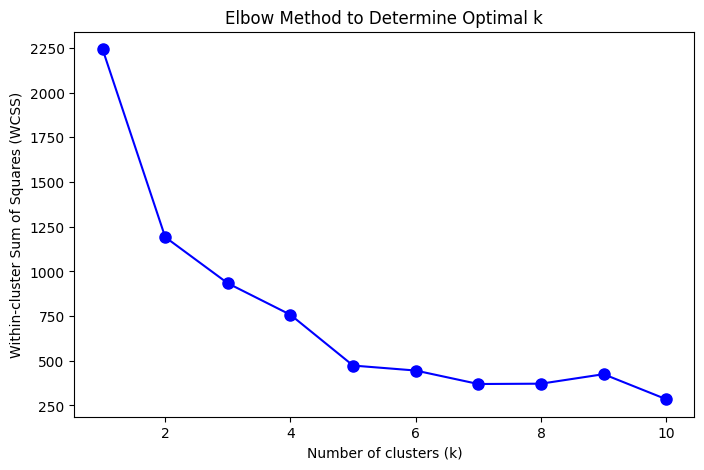

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt

wcss = []
K_range = range(1, 11)  # trying 1 to 10 clusters

for k in K_range:
    kmeans = MiniBatchKMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K_range, wcss, 'bo-', markersize=8)
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-cluster Sum of Squares (WCSS)')
plt.title('Elbow Method to Determine Optimal k')
plt.show()


The experiential parallel to a machine’s elbow plotting for identifying meaningful cluster counts is the distance scale from which a pattern is viewed. As you “zoom out” (or increase the number of clusters), broader structures emerge — up to a point. Beyond that, the view becomes an undifferentiated mass, and additional clusters only capture noise.

The elbow plot visualizes this with the Within-Cluster Sum of Squares (WCSS) — a measure of how tight the clusters are. Lower WCSS is better (tighter clusters), but the improvement slows down as k increases.

In this dataset, after around 6 clusters, the WCSS curve begins to flatten. That’s the “elbow,” suggesting that adding more clusters would result in diminishing returns, modeling noise rather than meaningful distinctions.



# K-Means

In [ ]:
optimal_k = 5

kmeans_final = MiniBatchKMeans(n_clusters=optimal_k, random_state=42)
clusters = kmeans_final.fit_predict(X_pca)

# Add cluster labels back to your clean DataFrame
df_clean['cluster'] = clusters


In [ ]:
df_clean.head()

,plant_code,state,steam_plant_type_full,year,sector,fuel_consump_all_fuel_types_mmbtu,gross_gen_mwh,net_gen_mwh,water_withdrawal_volume_mg,water_consumption_volume_mg,cluster
0,3,AL,Large Thermal Combustion Steam Plants (≥100 MW),2023,Electric Utility,617303.516667,82668.095890,80608.226027,7553.157600,71.428020,3
1,10,AL,Large Thermal Combustion Steam Plants (≥100 MW),2023,Electric Utility,568288.333333,58746.500000,54753.458333,10106.078333,0.000000,3
2,26,AL,Large Thermal Combustion Steam Plants (≥100 MW),2023,Electric Utility,507320.527778,50061.370370,45889.074074,6782.240741,142.833429,3
3,59,NE,Large Thermal Combustion Steam Plants (≥100 MW),2023,Electric Utility,340171.916667,33754.416667,30154.916667,37.000000,21.675000,2
4,60,NE,Large Thermal Combustion Steam Plants (≥100 MW),2023,Electric Utility,488964.291667,50996.750000,45645.916667,29.316870,21.617522,2


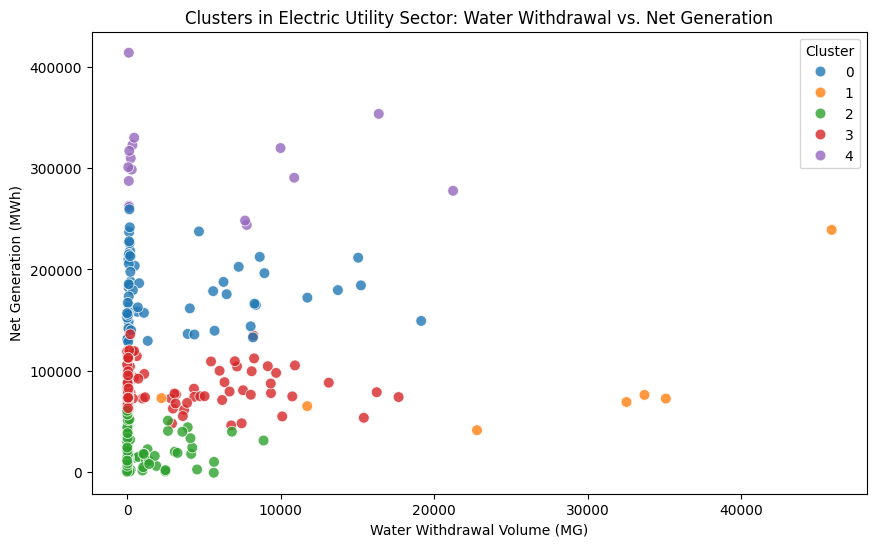

In [ ]:
import seaborn as sns
#import matplotlib.pyplot as plt

# Filter by sector if you want
sector_filter = 'Electric Utility'
df_sector = df_clean[df_clean['sector'] == sector_filter]

plt.figure(figsize=(10,6))
sns.scatterplot(
    data=df_sector,
    x='water_withdrawal_volume_mg',
    y='net_gen_mwh',
    hue='cluster',
    palette='tab10',
    s=60,
    alpha=0.8
)
plt.title(f'Clusters in {sector_filter} Sector: Water Withdrawal vs. Net Generation')
plt.xlabel('Water Withdrawal Volume (MG)')
plt.ylabel('Net Generation (MWh)')
plt.legend(title='Cluster')
plt.show()


## Discuss how and why the clusters make sense. If they don’t make sense, however, this is also useful insight, as it means you’ll need to explore the data further.

These clusters are particularly useful given the **non-linear relationships** between key variables in the dataset—especially those related to water usage. Without strong domain knowledge or a clear baseline for what qualifies as an anomaly, **unsupervised learning offers a way to surface structure** in the data that might not be immediately apparent.

Here’s how the clusters appear to break down:

* **Clusters 0, 2, 3, and 4** contain plants with **zero water withdrawal** but a range of net generation outputs. These are likely **air-cooled or closed-loop systems**, suggesting lower environmental water impact. The variation in generation indicates differences in plant size or fuel source.

* **Cluster 2** seems to represent **small, low-output facilities** with low to moderate water withdrawal. Possibly small-scale or less efficient plants.

* **Clusters 3 and 0** appear to group **mid-sized plants**, possibly **thermal combustion** types with more traditional water use profiles (up to \~20,000 million gallons).

* **Cluster 4** contains **high-output plants** (\~300,000–400,000 MWh) with surprisingly **low to moderate water withdrawal**. These might be **large, efficient facilities using advanced cooling systems**. One extreme outlier in this group warrants deeper inspection.

* **Cluster 1** is the most **diffuse**, with mid-level energy output but **very high water withdrawal**. This may signal **older or less efficient infrastructure**, perhaps **legacy coal plants**.

### Why These Clusters Matter

Even if the clusters don't map perfectly to known plant types, they **highlight patterns in the absence of clear ground truth**. For instance, the **prevalence of zero or missing water usage data** across different generation levels may reflect reporting inconsistencies, regional regulations, or technical setups—all of which deserve closer scrutiny.

Moreover, this clustering lays a foundation for **further analysis**: for example, by overlaying these groups with operational risk indicators or regional environmental policies. It gives us a starting point for identifying plants that are **underperforming, anomalous, or potentially misleading** based on their reported metrics.

## Calculate the descriptive statistics for your clusters using the groupby() function and discuss your findings. Propose what these results could be useful for in future steps of an analytics pipeline.

In [ ]:
# Descriptive stats by cluster
cluster_summary = df_clean.groupby('cluster')[['net_gen_mwh', 'water_withdrawal_volume_mg']].describe()
print(cluster_summary)


        net_gen_mwh                                               \
              count           mean            std            min   
cluster                                                            
0              77.0  175648.836838   34765.556192  115340.583333   
1              10.0  132578.622942  103711.950870   41167.708333   
2             178.0   22808.324215   17227.881286    -850.111111   
3             247.0   86923.804406   20060.255696   42198.722222   
4              26.0  331714.872960   87019.907637  243911.416667   

                                                                     \
                   25%            50%            75%            max   
cluster                                                               
0        148368.875000  171734.833333  202578.750000  269972.833333   
1         69837.750000   74437.995833  204675.786458  343095.636364   
2          7278.641204   20060.645833   37174.861979   60374.083333   
3         72890.333333   8622

### Cluster 1

Cluster 1 contains only 10 power plants, with a mean net generation of 132,578 MWh and a median of 74,438 MWh—suggesting that a few high-output plants are pulling the average upward. The minimum is 41,168 MWh, and with a standard deviation of 103,712 MWh (the highest of all clusters), these plants show a high degree of variability in energy output. Overall, they appear to be erratic but moderate producers.

Notably, Cluster 1 shows the highest water withdrawal volume of all clusters—averaging 27,523 million gallons, with some plants drawing over 53,000 MG. Although many still fall under the common 250,000 MG withdrawal threshold, this cluster stands out in terms of water intensity.

This raises some interpretive questions: Could these be medium-sized thermal combustion plants with complex configurations (e.g., combined cycle single shaft systems) that result in higher water demand or more volatile operational patterns? Alternatively, might they include older plants undergoing retrofits or plants with more intricate or error-prone water monitoring systems?

### Cluster 2 & 3

Cluster 2 includes the lowest electricity producers of 2023, with a maximum net generation of just 60,374 MWh. The minimum is -850 MWh, a disconcerting figure suggesting that at least one plant consumed more electricity than it produced over the year. This anomaly may warrant closer investigation—possibly a data entry error or an unusual Energy Storage unit (e.g., with a Compressed Air Energy Storage (CAES) or CSP configuration) where input exceeds output in a reporting cycle.

The mean water withdrawal (841 MG) is higher than the median (46 MG), suggesting the presence of a few outliers with disproportionately high water usage. These are likely skewing the cluster's overall average. Overall, Cluster 2 represents small or underutilized plants, with minimal water use and low output—perhaps peaker plants, plants on standby, or even decommissioning.

Cluster 3, in contrast, reflects a slightly larger but still modest generation profile, with a max output of circa 141,000 MWh and similar minimum value of 0. Its higher standard deviation in water withdrawal ( about 3,273 MG) compared to Cluster 2 reflects greater operational diversity or technological variation.

Taken together, Clusters 2 and 3 may represent a spectrum of smaller-to-mid-tier plants—some conventional, others atypical—whose water metrics vary based on technology, cooling systems, or plant age. Their inclusion helps fill out the ecosystem of non-major producers and may be crucial to understanding the lower end of generation infrastructure.

### Cluster 0 & 4

Clusters 0 and 4 represent the second-highest and highest electricity producers, respectively. Cluster 4 leads with a mean net generation of ~332,000 MWh, while Cluster 0 averages ~176,000 MWh. Both clusters exhibit strikingly similar water withdrawal patterns: mean values vastly exceed the median (by nearly 20x in some cases), suggesting that most plants operate with extremely low or near-zero water use, while a few outliers significantly inflate the average.

This skew implies the dominant use of closed-loop or air-cooled systems, which require minimal water withdrawal, or possibly plants with incomplete water reporting. Given their high and stable generation levels, these clusters likely capture the large-scale, baseload providers of the grid—such as large combustion turbines (likely in Cluster 0) and nuclear facilities (potentially within Cluster 4).

Their water-efficiency profiles and high output position them as critical infrastructure—both reliable and potentially optimized for environmental compliance. These clusters merit close attention as benchmarks or targets for scaling efficient tech to mid- and lower-performing groups.

# TL;DR & Next Steps
Clusters 0 & 4 likely represent the largest and most reliable power plants—critical infrastructure using efficient or minimal water withdrawal systems.
→ Use these as benchmarks for identifying what “healthy” plant performance looks like, both in terms of output and resource use.

Cluster 1 demands closer scrutiny: moderate producers with high water withdrawal and the highest variability in both electricity output and water metrics.
→ Could reflect outdated or diverse plant tech, or data entry inconsistencies. This group is ideal for targeting inefficiencies or auditing data quality.

Clusters 2 & 3 likely house smaller or transitional plants, given their low to moderate output.
→ Use these to define baseline expectations for the smallest segment of the fleet—but flag outliers (e.g. negative net generation in Cluster 2) for further validation. Some may be misclassified large plants in an unusual operational year (e.g. during retrofits or storage use).

